In [16]:
import yaml
import torch
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
import numpy as np

config = {
    "batchsize_train": 1,
    "batchsize_val": 1,
    "shuffle_train": True,
    "shuffle_val": False,
    "num_workers_train_loader": 5,
    "num_workers_val_loader": 5,
    "epochs": 10,
    "lr": 0.0001,
}

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from scipy.optimize import linear_sum_assignment
import h5py
from tqdm import tqdm
import hdf5plugin  # Required for reading HDF5 files with GZIP compression

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F


class GateDetectionNet(nn.Module):
    def __init__(self, num_gates=6, num_outputs_per_gate=12, conf_threshold=0.5):
        super(GateDetectionNet, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # Calculate the flattened size after convolution and pooling layers.
        # Assuming input size of (3, 480, 640)
        flattened_size = 128 * (480 // 8) * (640 // 8)

        self.fc1 = nn.Linear(flattened_size, 1024)
        self.fc2 = nn.Linear(1024, 512)

        # Predict gate attributes (x, y, visibility) for each gate
        self.gate_pred_layer = nn.Linear(512, num_gates * num_outputs_per_gate)

        # Predict confidence score for each gate
        self.conf_layer = nn.Linear(512, num_gates)

        # Initialize confidence layer bias to encourage initial predictions
        self.conf_layer.bias.data.fill_(0.1)  # Small positive bias

        self.num_gates = num_gates
        self.num_outputs_per_gate = num_outputs_per_gate
        self.conf_threshold = conf_threshold

    def forward(self, x):
        # Apply convolutional layers with ReLU activations and max pooling
        x = self.pool(F.relu(self.conv1(x)))  # Apply max pooling after relu
        x = self.pool(F.relu(self.conv2(x)))  # Apply max pooling again after relu
        x = self.pool(F.relu(self.conv3(x)))  # Apply max pooling again after relu
        x = F.relu(self.conv4(x))  # No pooling here

        # Flatten the feature maps to pass into the fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch

        # Fully connected layers with ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Predict gate attributes
        gate_pred = self.gate_pred_layer(
            x
        )  # Shape: (batch_size, num_gates * num_outputs_per_gate)
        # Predict confidence scores for each gate
        conf_pred = self.conf_layer(x)  # Shape: (batch_size, num_gates)

        # Reshape predictions to (batch_size, num_gates, num_outputs_per_gate)
        gate_pred = gate_pred.view(x.size(0), self.num_gates, self.num_outputs_per_gate)
        conf_pred = conf_pred.view(x.size(0), self.num_gates, 1)

        # Apply constraints to the x, y, and visibility values
        gate_pred[..., 0::3] = torch.sigmoid(
            gate_pred[..., 0::3]
        )  # Constrain all x values to [0, 1]
        gate_pred[..., 1::3] = torch.sigmoid(
            gate_pred[..., 1::3]
        )  # Constrain all y values to [0, 1]
        gate_pred[..., 2::3] = (
            torch.sigmoid(gate_pred[..., 2::3]) * 2
        )  # Constrain visibility to [0, 2]

        # Apply sigmoid to the confidence prediction
        conf_pred = torch.sigmoid(conf_pred)  # Shape: (batch_size, num_gates, 1)

        # Filter out predictions based on the confidence threshold
        keep_mask = conf_pred > self.conf_threshold  # Shape: (batch_size, num_gates, 1)

        # Apply the mask to filter the predictions
        filtered_gate_pred = gate_pred[keep_mask.expand_as(gate_pred)].view(
            x.size(0), -1, self.num_outputs_per_gate
        )  # Shape: (batch_size, num_filtered_gates, num_outputs_per_gate)
        filtered_conf_pred = conf_pred[keep_mask].view(
            x.size(0), -1, 1
        )  # Shape: (batch_size, num_filtered_gates, 1)

        return filtered_gate_pred

In [19]:
import torch

model = GateDetectionNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# force cpu as dvice
# device = torch.device("cpu")
model = model.to(device)
print(f"Device: {device}")

Device: cuda


In [20]:
import torch
from torch.utils.data import Dataset
import h5py


class GateDetectionDataset(Dataset):
    def __init__(self, h5_file_path):
        """
        Initialize the dataset by loading the HDF5 file.

        Args:
            h5_file_path (str): Path to the HDF5 file containing images and targets.
        """
        # Open the HDF5 file
        self.h5f = h5py.File(h5_file_path, "r")

        # Load images and targets into the dataset
        self.images = self.h5f["images"]
        self.targets = [
            self.h5f[f"targets/{i:05d}"][()] for i in range(len(self.images))
        ]

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retrieve a sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            image (torch.Tensor): The image as a torch tensor.
            target (torch.Tensor): The corresponding target for the image.
        """
        # Load image and target
        image = self.images[idx]  # Image as numpy array
        target = self.targets[idx]  # Target as numpy array

        # Convert to torch tensors
        image = torch.tensor(image, dtype=torch.float32)  # Convert to float tensor
        target = torch.tensor(target, dtype=torch.float32)  # Convert to float tensor

        return image, target

    def __del__(self):
        """Close the HDF5 file when the object is deleted."""
        self.h5f.close()

In [21]:
from torch.utils.data import DataLoader, random_split, Dataset

data_path = "/workspaces/AE4353-Y24/competition/data/Autonomous/autonomous_flight-01a-ellipse.h5"
dataset = GateDetectionDataset(data_path)

# Split the dataset into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


# Create training set loader
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=config["num_workers_train_loader"],
)

# Create validation set loader
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batchsize_val"],
    shuffle=False,
    num_workers=config["num_workers_val_loader"],
)
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

In [22]:
import torch
from scipy.optimize import linear_sum_assignment


def matching_loss(
    pred,
    target,
    penalty_per_gate=35,
    coord_loss_weight=1.0,
    vis_loss_weight=0.5,
):
    """
    Custom loss function to penalize unmatched gates and excess gates.

    Args:
        pred (torch.Tensor): Predicted tensor of shape (batch_size, num_pred_gates, 12).
        target (torch.Tensor): Target tensor of shape (batch_size, num_target_gates, 12).
        penalty_per_gate (float): Penalty for each gate more or less than the target.

    Returns:
        loss (torch.Tensor): Calculated loss for the batch.
    """
    batch_size = pred.size(0)
    total_loss = torch.tensor(0.0, device=pred.device, requires_grad=True)

    for i in range(batch_size):
        pred_gates = pred[i]  # Predicted gates for one sample in batch
        target_gates = target[i]  # Target gates for one sample in batch

        num_pred = pred_gates.size(0)
        num_target = target_gates.size(0)

        # If either num_pred or num_target is zero, directly compute the penalty
        if num_pred == 0 or num_target == 0:
            unmatched_penalty = penalty_per_gate * abs(num_pred - num_target)
            unmatched_penalty = torch.tensor(unmatched_penalty, device=pred.device)
            total_loss = total_loss + unmatched_penalty
            continue

        # Vectorized calculation of cost matrix
        pred_exp = pred_gates.unsqueeze(1)  # Shape: (num_pred, 1, 12)
        target_exp = target_gates.unsqueeze(0)  # Shape: (1, num_target, 12)

        # Compute squared distances between predicted and target coordinates
        coord_dist = torch.sum(
            (pred_exp[..., :2] - target_exp[..., :2]) ** 2, dim=-1
        )  # Shape: (num_pred, num_target)

        # Calculate visibility penalty separately
        vis_penalty = (
            torch.sum((pred_exp[..., 2:12:3] - target_exp[..., 2:12:3]) ** 2, dim=-1)
        ) / 4  # Shape: (num_pred, num_target)

        # Total cost matrix, weighted by individual losses
        cost_matrix = coord_loss_weight * coord_dist + vis_loss_weight * vis_penalty

        # Use the Hungarian algorithm for optimal matching
        cost_matrix_np = cost_matrix.detach().cpu().numpy()
        row_ind, col_ind = linear_sum_assignment(cost_matrix_np)

        # Calculate matching loss
        matching_loss = torch.sum(cost_matrix[row_ind, col_ind])

        # Calculate penalty based on more or fewer predicted gates

        if num_pred < num_target:
            unmatched_penalty = penalty_per_gate * abs(num_pred - num_target)
            unmatched_penalty = torch.tensor(unmatched_penalty, device=pred.device)
        else:
            unmatched_penalty = 0

        # Total loss for the current batch sample
        total_loss = total_loss + matching_loss + unmatched_penalty

    # Average loss over the batch
    total_loss = total_loss / batch_size
    return total_loss

In [23]:
def evaluate(val_loader, model, device):
    model.eval()
    val_loss = 0.0
    val_error_tensor = []
    val_pred = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Get model predictions and confidence scores
            outputs = model(inputs)

            # Post-process predictions before calculating the loss

            # Calculate loss using the loss function
            loss = matching_loss(outputs, targets)

            val_loss += loss.item() * inputs.size(0)

            # Append loss to error tensor for tracking performance
            val_error_tensor.append(loss.item())
            val_pred.append(outputs)

    # Calculate average loss for the epoch
    val_loss /= len(val_loader.dataset)

    # Convert error tensor to a torch tensor
    val_error_tensor = torch.tensor(val_error_tensor, device=device)
    val_mean = val_error_tensor.mean().item()
    val_median = val_error_tensor.median().item()

    val_perf = (val_mean, val_median, val_error_tensor)

    return val_loss, val_perf, val_pred

In [24]:
import time
import torch
from tqdm import tqdm


def train_epoch(train_loader, model, optimizer, device):
    model.train()
    train_loss = 0.0
    train_error_tensor = []

    total_batches = len(train_loader)
    print_interval = total_batches // 20  # 5% of total batches

    for batch_idx, (inputs, targets) in enumerate(
        tqdm(train_loader, desc="Training Batches", leave=False)
    ):
        # Measure data loading time
        # data_load_start = time.time()
        inputs, targets = inputs.to(device), targets.to(device)
        # data_load_time = time.time() - data_load_start
        # print(f"Data Loading Time: {data_load_time:.4f} seconds")

        # Measure forward pass time
        # forward_start = time.time()
        outputs = model(inputs)
        # forward_time = time.time() - forward_start
        # print(f"Forward Pass Time: {forward_time:.4f} seconds")

        # Measure loss calculation time
        # loss_start = time.time()
        loss = matching_loss(outputs, targets)
        # loss_time = time.time() - loss_start
        # print(f"Loss Calculation Time: {loss_time:.4f} seconds")

        # Measure backward pass time
        # backward_start = time.time()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # backward_time = time.time() - backward_start
        # print(f"Backward Pass Time: {backward_time:.4f} seconds")

        # Update loss and error metrics
        train_loss += loss.item() * inputs.size(0)
        train_error_tensor.append(loss.item())

        # Print progress every 5% of the training loop
        if (batch_idx + 1) % print_interval == 0:
            print(
                f"Progress: {(batch_idx + 1) / total_batches * 100:.2f}% - Loss: {loss.item():.4f}"
            )

    # Calculate average loss for the epoch
    train_loss /= len(train_loader.dataset)
    train_error_tensor = torch.tensor(train_error_tensor, device=device)
    train_mean = train_error_tensor.mean().item()
    train_median = train_error_tensor.median().item()
    train_perf = (train_mean, train_median, train_error_tensor)

    return train_loss, train_perf

In [25]:
torch.cuda.empty_cache()

In [26]:
from torch.utils.tensorboard import SummaryWriter

# Example usage with the provided epoch loop
# Assuming you have defined the necessary elements: train_loader, val_loader, model, optimizer, device, and config
exp_name = "NEWMODEL"
writer = SummaryWriter(f"runs/{exp_name}", comment="")
epochs = config["epochs"]
print(f"learning rate: {config['lr']}")

for epoch in tqdm(range(epochs), desc="Epochs"):
    # Train the model for one epoch
    train_loss, train_perf = train_epoch(train_loader, model, optimizer, device)
    train_mean, train_median, train_error_tensor = train_perf

    # Evaluate the model on validation set
    val_loss, val_perf, val_pred = evaluate(val_loader, model, device)
    val_mean, val_median, val_error_tensor = val_perf

    # Logging training metrics
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Error/train/mean", train_mean, epoch)
    writer.add_scalar("Error/train/median", train_median, epoch)
    writer.add_histogram("Error/train", train_error_tensor, epoch)

    # Logging validation metrics
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Error/val/mean", val_mean, epoch)
    writer.add_scalar("Error/val/median", val_median, epoch)
    writer.add_histogram("Error/val", val_error_tensor, epoch)
    # writer.add_histogram(
    #     "Pred/val", torch.cat([pred.flatten() for pred in val_pred]), epoch
    # )

    # Clear GPU cache
    torch.cuda.empty_cache()

writer.close()

# Clear GPU cache
torch.cuda.empty_cache()

learning rate: 0.0001


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x614400 and 153600x1024)

Ground Truth Coordinates: tensor([[0.4297, 0.5660, 2.0000, 0.6312, 0.5310, 2.0000, 0.6575, 0.9046, 2.0000,
         0.4364, 0.9346, 2.0000],
        [0.1688, 0.5997, 2.0000, 0.3019, 0.5858, 2.0000, 0.2941, 0.9255, 2.0000,
         0.1572, 0.8880, 2.0000]])


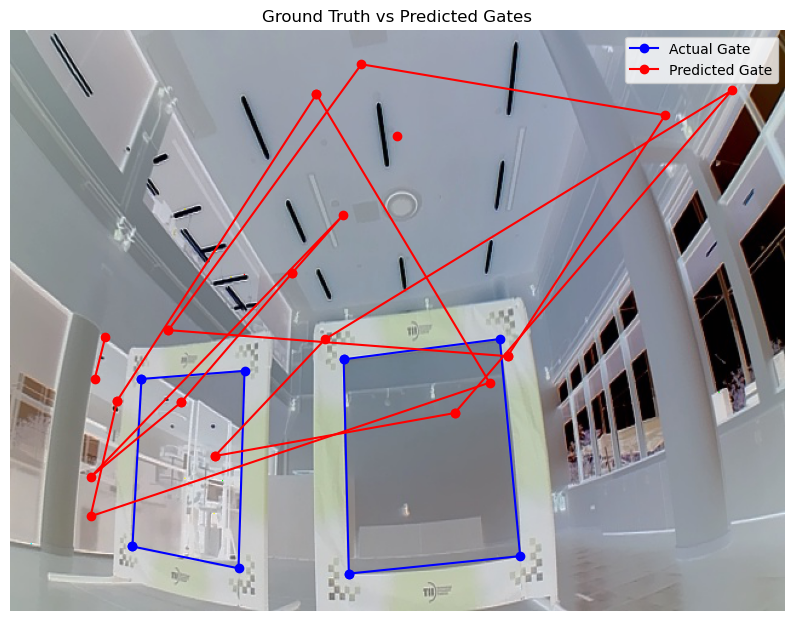

In [15]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Define visibility threshold
visibility_threshold = 1.5  # Change this value to set the visibility threshold

# Load the first image and target from the dataset
image, target = dataset[0]  # Adjust the index if you want a different image
image = image.to(device)  # Move image to GPU if necessary

# Get ground truth coordinates
gt_coords = target  # Target is already in (num_gates, 12) format

print(f"Ground Truth Coordinates: {gt_coords}")

# Ensure the model is in evaluation mode
model.eval()

# Predict the gates using the model
with torch.no_grad():
    pred_coords = model(image.unsqueeze(0))  # Add batch dimension

# Move tensors to CPU for visualization
image = image.cpu().numpy().transpose(1, 2, 0)  # Convert image to HWC format
pred_coords = pred_coords.squeeze(0).cpu().numpy()  # Remove batch dimension
gt_coords = gt_coords.cpu().numpy()

# Undo normalization if necessary (assuming image was normalized)
image = (image * 255).astype(np.uint8)

# Create a figure for the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")


# Function to plot gates
def plot_gates(gate_coords, color, label_prefix, image_shape, visibility_threshold):
    for i, gate in enumerate(gate_coords):
        # Reshape gate into (4, 3) format for (x, y, visibility) per point
        gate_points = gate.reshape(-1, 3)

        # Convert relative coordinates to absolute pixel values
        xy = gate_points[:, :2] * image_shape[1::-1]
        visibility = gate_points[:, 2]

        # Plot points with visibility >= visibility_threshold
        plt.plot(
            xy[visibility >= visibility_threshold, 0],
            xy[visibility >= visibility_threshold, 1],
            f"{color}o-",
            markerfacecolor=color,
            label=f"{label_prefix} Gate" if i == 0 else "",
        )

        # Close the loop if all points have visibility >= visibility_threshold
        if np.all(visibility >= visibility_threshold):
            plt.plot([xy[-1, 0], xy[0, 0]], [xy[-1, 1], xy[0, 1]], f"{color}o-")


# Plot ground truth gates in blue
plot_gates(gt_coords, "b", "Actual", image.shape, visibility_threshold)

# Plot predicted gates in red
plot_gates(pred_coords, "r", "Predicted", image.shape, visibility_threshold)

# Add legend and show the plot
plt.legend()
plt.title("Ground Truth vs Predicted Gates")
plt.show()